<a href="https://colab.research.google.com/github/Disha-Sikka/Dog-Breed-Classification/blob/main/dogs_breed_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [38]:
!kaggle competitions download -c ssd-3-l-dog-breed-classification


ssd-3-l-dog-breed-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [39]:
import zipfile
zip_ref= zipfile.ZipFile('/content/ssd-3-l-dog-breed-classification.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [40]:
import os

BASE_DIR = "/content/dog_breed_competition"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")
CHECKPOINT_DIR = os.path.join(BASE_DIR, "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

IMG_SIZE = 128
NUM_CLASSES = 157
BATCH_SIZE = 32
EPOCHS = 25
LR = 1e-3

import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cuda


In [41]:
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


In [42]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ToTensor()
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_ds = datasets.ImageFolder(VAL_DIR, transform=val_test_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

idx_to_class = {v: k for k, v in train_ds.class_to_idx.items()}

In [43]:
class DogCNN(nn.Module):
    def __init__(self, num_classes=157):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = DogCNN(num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

In [44]:
train_losses, val_losses, val_accs = [], [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc)

    print(f"✅ Epoch {epoch+1}: Val Acc = {100*val_acc:.2f}%, Train Loss = {train_losses[-1]:.4f}")
    torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"model_epoch{epoch+1}.pth"))
    scheduler.step()


Epoch 1/25: 100%|██████████| 381/381 [01:13<00:00,  5.17it/s]


✅ Epoch 1: Val Acc = 0.92%, Train Loss = 4.8368


Epoch 2/25: 100%|██████████| 381/381 [01:13<00:00,  5.16it/s]


✅ Epoch 2: Val Acc = 0.88%, Train Loss = 4.6289


Epoch 3/25: 100%|██████████| 381/381 [01:13<00:00,  5.19it/s]


✅ Epoch 3: Val Acc = 1.72%, Train Loss = 4.5634


Epoch 4/25: 100%|██████████| 381/381 [01:13<00:00,  5.20it/s]


✅ Epoch 4: Val Acc = 0.84%, Train Loss = 4.5163


Epoch 5/25: 100%|██████████| 381/381 [01:15<00:00,  5.08it/s]


✅ Epoch 5: Val Acc = 1.68%, Train Loss = 4.4719


Epoch 6/25: 100%|██████████| 381/381 [01:15<00:00,  5.07it/s]


✅ Epoch 6: Val Acc = 1.87%, Train Loss = 4.4034


Epoch 7/25: 100%|██████████| 381/381 [01:13<00:00,  5.18it/s]


✅ Epoch 7: Val Acc = 2.14%, Train Loss = 4.3839


Epoch 8/25: 100%|██████████| 381/381 [01:13<00:00,  5.20it/s]


✅ Epoch 8: Val Acc = 2.33%, Train Loss = 4.3640


Epoch 9/25: 100%|██████████| 381/381 [01:13<00:00,  5.18it/s]


✅ Epoch 9: Val Acc = 1.95%, Train Loss = 4.3489


Epoch 10/25: 100%|██████████| 381/381 [01:13<00:00,  5.20it/s]


✅ Epoch 10: Val Acc = 2.79%, Train Loss = 4.3311


Epoch 11/25: 100%|██████████| 381/381 [01:14<00:00,  5.11it/s]


✅ Epoch 11: Val Acc = 2.37%, Train Loss = 4.2894


Epoch 12/25: 100%|██████████| 381/381 [01:13<00:00,  5.20it/s]


✅ Epoch 12: Val Acc = 3.02%, Train Loss = 4.2822


Epoch 13/25: 100%|██████████| 381/381 [01:13<00:00,  5.16it/s]


✅ Epoch 13: Val Acc = 2.83%, Train Loss = 4.2618


Epoch 14/25: 100%|██████████| 381/381 [01:13<00:00,  5.16it/s]


✅ Epoch 14: Val Acc = 2.79%, Train Loss = 4.2502


Epoch 15/25: 100%|██████████| 381/381 [01:13<00:00,  5.16it/s]


✅ Epoch 15: Val Acc = 2.68%, Train Loss = 4.2498


Epoch 16/25: 100%|██████████| 381/381 [01:13<00:00,  5.16it/s]


✅ Epoch 16: Val Acc = 3.29%, Train Loss = 4.2250


Epoch 17/25: 100%|██████████| 381/381 [01:13<00:00,  5.18it/s]


✅ Epoch 17: Val Acc = 2.87%, Train Loss = 4.2174


Epoch 18/25: 100%|██████████| 381/381 [01:13<00:00,  5.17it/s]


✅ Epoch 18: Val Acc = 2.98%, Train Loss = 4.2125


Epoch 19/25: 100%|██████████| 381/381 [01:13<00:00,  5.19it/s]


✅ Epoch 19: Val Acc = 3.33%, Train Loss = 4.1985


Epoch 20/25: 100%|██████████| 381/381 [01:13<00:00,  5.19it/s]


✅ Epoch 20: Val Acc = 2.98%, Train Loss = 4.1999


Epoch 21/25: 100%|██████████| 381/381 [01:12<00:00,  5.22it/s]


✅ Epoch 21: Val Acc = 2.94%, Train Loss = 4.1889


Epoch 22/25: 100%|██████████| 381/381 [01:13<00:00,  5.19it/s]


✅ Epoch 22: Val Acc = 2.75%, Train Loss = 4.1813


Epoch 23/25: 100%|██████████| 381/381 [01:13<00:00,  5.17it/s]


✅ Epoch 23: Val Acc = 3.10%, Train Loss = 4.1709


Epoch 24/25: 100%|██████████| 381/381 [01:13<00:00,  5.17it/s]


✅ Epoch 24: Val Acc = 2.98%, Train Loss = 4.1738


Epoch 25/25: 100%|██████████| 381/381 [01:13<00:00,  5.16it/s]


✅ Epoch 25: Val Acc = 3.17%, Train Loss = 4.1754


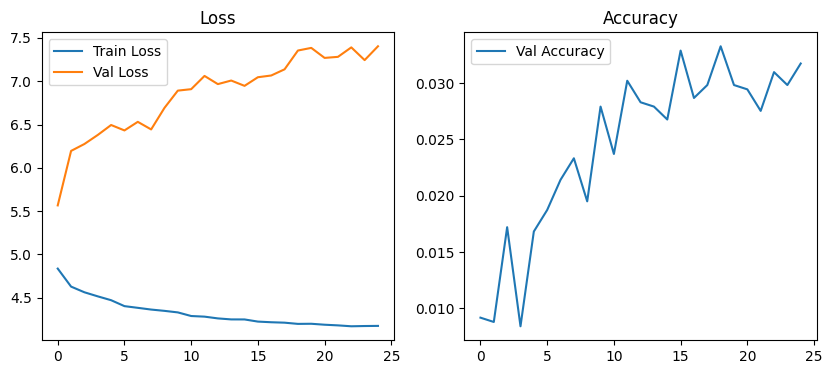

In [45]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accs, label="Val Accuracy")
plt.title("Accuracy")
plt.legend()

plt.savefig(os.path.join(BASE_DIR, "dog_metrics_plot.png"))
plt.show()


In [47]:
import os
import shutil

test_dir = TEST_DIR
for subdir in os.listdir(test_dir):
    sub_path = os.path.join(test_dir, subdir)
    if os.path.isdir(sub_path):
        for file in os.listdir(sub_path):
            shutil.move(os.path.join(sub_path, file), test_dir)
        os.rmdir(sub_path)

In [48]:
from torch.utils.data import Dataset
from PIL import Image

class TestDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.image_ids = sorted(os.listdir(path))
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image = Image.open(os.path.join(self.path, image_id)).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, image_id

test_ds = TestDataset(TEST_DIR, transform=val_test_transforms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

model.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, f"model_epoch{EPOCHS}.pth")))
model.eval()

predictions = []
with torch.no_grad():
    for imgs, img_ids in tqdm(test_loader, desc="Predicting"):
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        for img_id, pred in zip(img_ids, preds):
            predictions.append([img_id, idx_to_class[pred]])

import csv
submission_path = os.path.join(BASE_DIR, "submission.csv")
with open(submission_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["image_id", "label"])
    writer.writerows(predictions)

print("✅ submission.csv saved to:", submission_path)

Predicting: 100%|██████████| 85/85 [00:11<00:00,  7.38it/s]

✅ submission.csv saved to: /content/dog_breed_competition/submission.csv
